<a href="https://colab.research.google.com/github/JayKarhade/MI_VCG_DL/blob/main/MI_Detection_mode12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
import glob 
import PIL
import sklearn
import numpy as np
import pandas as pd
import scipy.io as sio 
import matplotlib.pyplot as plt
import warnings 
import cv2
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Activation, Flatten, Dropout,BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import SGD,Adam
from keras.utils import np_utils
from sklearn.utils import shuffle
from PIL import Image
from tensorflow.keras.regularizers import l2
#from keras.utils import to_categorical
from scipy.io import loadmat
from keras import layers
import keras
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

**Data Preparation**

In [ ]:
x = loadmat('/content/drive/MyDrive/MI_Files/myocardial_infarction/s0042lrem/matlab.mat')
print(len(x['chm']))
print(len(x['chm'][0]))
print(len(x['chm'][0][0]))
print(len(x['chm'][0][0][0]))

3
151
5
651


In [ ]:
x['chm']

In [ ]:

folder_path_class1 = '/content/drive/MyDrive/MI_Files/healthy'
folder_path_class2 = '/content/drive/MyDrive/MI_Files/myocardial_infarction'
my_list_class1 = os.listdir(folder_path_class1)
my_list_class2 = os.listdir(folder_path_class2)

data_load = []
sum = 0
y = []
for i in range(len(my_list_class1)):
  address = folder_path_class1+'/'+my_list_class1[i]+'/matlab.mat'
  temp_data = np.asarray(loadmat(address)['chm'].T)##Get each file content
  for j in range(temp_data.shape[0]):
    data_load.append(temp_data[j])##Append all instances in each .mat file to data_load
    y.append(0)##Class Label
  #sum = sum + temp_data.shape[0]##Debugging step to make sure all instances are done

#data_load = np.asarray(data_load)
#print(data_load.shape)
#print(sum)
for i in range(len(my_list_class2)):
  address = folder_path_class2+'/'+my_list_class2[i]+'/matlab.mat'
  temp_data = np.asarray(loadmat(address)['chm'].T)##Get each file content
  for j in range(temp_data.shape[0]):
    data_load.append(temp_data[j])##Append all instances in each .mat file to data_load
    y.append(1) #Class Label
  #sum = sum + temp_data.shape[0]##Debugging step to make sure all instances are done

data_load = np.asarray(data_load)
y = np.asarray(y)
print(y.shape)
print(data_load.shape)
print(sum)

#dataset = np.zeros([23696,15,651]) ##considers 5 modes
dataset = np.zeros([23696,6,651])

##for 5 modes
#for i in range(23696): ##total number of instances
#  for j in range(3): ##number of channels/beats of vcg
#    for k in range(5): ##number of modes
#      dataset[i,(5*j) + k] = data_load[i][j][k]
##for 2 modes
for i in range(23696):
  for j in range(3):
    for k in range(2):
      dataset[i,(2*j) + k] = data_load[i][j][k]

data = np.zeros([23696,651,6])
for i in range(23696):
  data[i] = dataset[i].T


#np.save("/content/drive/MyDrive/MI_Files/MI_label_mode12.npy",y)
#np.save("/content/drive/MyDrive/MI_Files/MIdata_12.npy",data)

(23696,)
(23696, 3)
0


**Run from here**

In [ ]:
data = np.load("/content/drive/MyDrive/MI_Files/MIdata_12.npy")
y = np.load("/content/drive/MyDrive/MI_Files/MI_label_mode12.npy")

In [ ]:
data.shape

(23696, 651, 6)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/8, random_state=1)


y_tr_one_hot  = np.zeros((np.array(y_train).shape[0],2))

for i in range(np.array(y_train).shape[0]):
 label = y_train[i]
 y_tr_one_hot[i][int(label)] = 1

#y_tr_one_hot = to_categorical(y_train)
#y_val_one_hot= to_categorical(y_val)

In [ ]:
##Define model
def model_define():
  model=Sequential()
  model.add(Conv1D(filters=20, kernel_size=5, activation='relu',input_shape=(651,6)))
  model.add(MaxPooling1D(pool_size=3, strides = 3))
  model.add(Conv1D(filters=60, kernel_size=5, activation='relu'))
  #model.add(Dropout(0.7))
  model.add(MaxPooling1D(pool_size=3, strides = 5))
  model.add(Conv1D(filters=120, kernel_size=5,))
  model.add(Conv1D(filters=120,kernel_size=7,))
  model.add(Flatten())
  model.add(Dense(2000, activation='relu'))
  model.add(Dense(700, activation='relu'))
  model.add(Dense(50,activation='relu'))
  model.add(Dense(2,activation='sigmoid'))
  return model

for iter in range(5):
  x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=1)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/8, random_state=1)


  y_tr_one_hot  = np.zeros((np.array(y_train).shape[0],2))

  for i in range(np.array(y_train).shape[0]):
    label = y_train[i]
    y_tr_one_hot[i][int(label)] = 1

  K.clear_session()
  modelf = model_define()

  #print(modelf.summary())
  optimizer = keras.optimizers.Adam(lr=0.0001)
  modelf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  y_val_one_hot  = np.zeros((np.array(y_val).shape[0],2))

  for i in range(np.array(y_val).shape[0]):
    label = y_val[i]
    y_val_one_hot[i][int(label)] = 1

  hist = modelf.fit(np.array(x_train), y_tr_one_hot, validation_data=(np.array(x_val), y_val_one_hot), epochs=15, batch_size=1024)

  y_te_one_hot  = np.zeros((np.array(y_test).shape[0],2))

  for i in range(np.array(y_test).shape[0]):
    label = y_test[i]
    y_te_one_hot[i][int(label)] = 1

  test_loss, test_acc = modelf.evaluate(np.array(x_test), np.array(y_te_one_hot), verbose=0)
  print('Accuracy:',test_acc)

  ##Evaluating Sensitivity, Accuracy and Kappa scores

  Y_pred = modelf.predict_classes(x_test)

  K_cappa = sklearn.metrics.cohen_kappa_score(y_test,Y_pred)
  print("cohen kappa scores:" ,K_cappa)

  cm1 = confusion_matrix(y_test,Y_pred)
  print("confusion matrix \n",cm1)

  sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
  print('Sensitivity : ', sensitivity1 )

  specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
  print('Specificity : ', specificity1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15
19/19 [==============================] - 45s 200ms/step - loss: 0.5324 - accuracy: 0.7054 - val_loss: 0.2377 - val_accuracy: 0.9002
Epoch 2/15
19/19 [==============================] - 2s 111ms/step - loss: 0.2094 - accuracy: 0.9064 - val_loss: 0.1702 - val_accuracy: 0.9314
Epoch 3/15
19/19 [==============================] - 2s 109ms/step - loss: 0.1316 - accuracy: 0.9482 - val_loss: 0.1057 - val_accuracy: 0.9572
Epoch 4/15
19/19 [==============================] - 2s 111ms/step - loss: 0.0883 - accuracy: 0.9650 - val_loss: 0.0594 - val_accuracy: 0.9790
Epoch 5/15
19/19 [==============================] - 2s 110ms/step - loss: 0.0455 - accuracy: 0.9841 - val_loss: 0.0358 - val_accuracy: 0.9891
Epoch 6/15
19/19 [==============================] - 2s 111ms/step - loss: 0.0252 - accuracy: 0.9911 - val_loss: 0.0172 - val_accuracy: 0.9955
Epoch 7/15
19/19 [==============================] - 2s 109ms/step - loss: 0.0128 - accuracy: 0.9966 - val_loss: 0.0125 - val_accuracy: 0.9959
Epoch

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


cohen kappa scores: 0.9869729352193933
confusion matrix 
 [[ 978    1]
 [  14 1377]]
Sensitivity :  0.9989785495403473
Specificity :  0.9899352983465133
Epoch 1/15
19/19 [==============================] - 4s 137ms/step - loss: 0.5246 - accuracy: 0.7166 - val_loss: 0.2656 - val_accuracy: 0.8818
Epoch 2/15
19/19 [==============================] - 2s 110ms/step - loss: 0.2105 - accuracy: 0.9047 - val_loss: 0.1376 - val_accuracy: 0.9494
Epoch 3/15
19/19 [==============================] - 2s 110ms/step - loss: 0.1059 - accuracy: 0.9609 - val_loss: 0.0759 - val_accuracy: 0.9726
Epoch 4/15
19/19 [==============================] - 2s 117ms/step - loss: 0.0593 - accuracy: 0.9802 - val_loss: 0.0517 - val_accuracy: 0.9831
Epoch 5/15
19/19 [==============================] - 2s 109ms/step - loss: 0.0325 - accuracy: 0.9896 - val_loss: 0.0238 - val_accuracy: 0.9932
Epoch 6/15
19/19 [==============================] - 2s 110ms/step - loss: 0.0160 - accuracy: 0.9957 - val_loss: 0.0285 - val_accuracy: 0.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


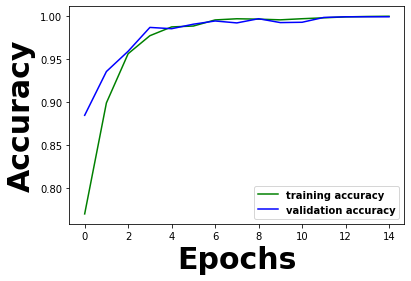

In [ ]:
##Plot results
import matplotlib.pyplot as plt

loss_train = hist.history['accuracy']
loss_val = hist.history['val_accuracy']
epochs = range(0,15)
plt.plot(epochs, loss_train, 'g', label='training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
#plt.title('Training and Validation accuracy')
plt.xlabel('Epochs', fontsize=30, fontweight='bold')
plt.ylabel('Accuracy',fontsize=30,  fontweight='bold')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

plt.legend()
plt.show()

**K-Fold Cross Validation**

In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data_cv = data[indices]
y_cv = y[indices]

In [ ]:
y_one_hot  = np.zeros((np.array(y_cv).shape[0],2))

for i in range(np.array(y_cv).shape[0]):
  label = y_cv[i]
  y_one_hot[i][int(label)] = 1

In [ ]:
##Cross Validation
folds=10
kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1)
#cvscores = []

for train,test in kfold.split(data_cv,y_cv):
  model=Sequential()
  model.add(Conv1D(filters=20, kernel_size=5, activation='relu',input_shape=(651,15)))
  model.add(MaxPooling1D(pool_size=3, strides = 3))
  model.add(Conv1D(filters=60, kernel_size=5, activation='relu'))
  #model.add(Dropout(0.7))
  model.add(MaxPooling1D(pool_size=3, strides = 5))
  model.add(Conv1D(filters=120, kernel_size=5,))
  model.add(Conv1D(filters=120,kernel_size=7,))
  model.add(Flatten())
  model.add(Dense(2000, activation='relu'))
  model.add(Dense(700, activation='relu'))
  model.add(Dense(50,activation='relu'))
  model.add(Dense(2,activation='sigmoid'))
  
  opt = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  #Train
  model.fit(data_cv[train], y_one_hot[train],batch_size=1024,epochs=15,verbose=1)
  #Test
  test_loss, test_acc = model.evaluate(data_cv[test],y_one_hot[test],batch_size=8, verbose=1)
  #Metrics
  print('Accuracy:',test_acc)
  Y_pred = model.predict_classes(data_cv[test])

  K_cappa = sklearn.metrics.cohen_kappa_score(y_cv[test],Y_pred)
  print("cohen kappa scores:" ,K_cappa)

  cm1 = confusion_matrix(y_cv[test],Y_pred)
  print("confusion matrix \n",cm1)

  sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
  print('Sensitivity : ', sensitivity1 )

  specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
  print('Specificity : ', specificity1)

  #cvscores.append(test_acc)
  K.clear_session()

NameError: ignored